<a href="https://www.kaggle.com/code/wahyudewo/spacex-falcon-9-landing-projection-lab-1?scriptVersionId=121939581" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime
# Library for visualization
import plotly.express as px

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [2]:
# Request and parse the SpaceX launch data using the GET request
urls = {
    'launch': 'https://api.spacexdata.com/v4/launches/past',
    'static_launch': 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json',
    'capsules': 'https://api.spacexdata.com/v4/capsules',
    'cores': 'https://api.spacexdata.com/v4/cores',
    'rockets' : 'https://api.spacexdata.com/v4/rockets',
    'launchpads' : 'https://api.spacexdata.com/v4/launchpads',
    'payloads' : 'https://api.spacexdata.com/v4/payloads',
}

for url_names, url in urls.items():
    response = requests.get(url).json()
    df_name = f'{url_names}'
    globals()[df_name] = pd.json_normalize(response)

In [3]:
data = static_launch.copy()

# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date_utc'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date_utc'] <= datetime.date(2020, 11, 13)]

In [4]:
core = pd.json_normalize(data.cores)
core['Outcome'] = core.landing_success.astype('str') + ' ' + core.landing_type.astype('str')

In [5]:
# Combine the data with merge function
merge = data\
        .merge(rockets.name,
               how='left',
               left_on='rocket',
               right_on=rockets.id,
               suffixes=('','_rocket'),
              )\
        .merge(launchpads[['longitude','latitude','name']],
               how='left',
               left_on='launchpad',
               right_on=launchpads.id,
               suffixes=('','_launchpad'),
              )\
        .merge(payloads[['mass_kg','orbit']],
               how='left',
               left_on='payloads',
               right_on=payloads.id,
               suffixes=('','_payloads'),
              )\
        .merge(core,
               how='left',
               left_index=True,
               right_index=True,
              )\
        .merge(cores[['block','reuse_count','serial']],
               how='left',
               left_on='core',
               right_on=cores.id,
              )\

In [6]:
# Construct the dataset using the data we have obtained. Select only column we need
merge = merge [[
#     'rocket', 'payloads', 'launchpad', 'cores',
    'flight_number', 'date_utc','name', 'mass_kg', 'orbit', 'name_launchpad',
#     'core',
    'Outcome', 'flight', 'gridfins', 'legs', 'reused',
#     'landing_attempt', 'landing_success', 'landing_type',
    'landpad', 'block', 'reuse_count', 'serial', 'longitude', 'latitude'
]].rename(columns = {
    'flight_number':'FlightNumber',
    'date_utc':'Date',
    'name':'BoosterVersion',
    'mass_kg':'PayloadMass',
    'orbit':'Orbit',
    'name_launchpad':'LaunchSite',
    'flight':'Flights',
    'gridfins':'GridFins',
    'reused':'Reused',
    'legs':'Legs',
    'landpad':'LandingPad',
    'block':'Block',
    'reuse_count':'ReusedCount',
    'serial':'Serial',
    'longitude':'Longitude',
    'latitude':'Latitude',
                  }
         )
merge.Date = merge.Date.astype('datetime64')

In [7]:
# Keeping only the Falcon 9 launches
data_falcon9 = merge.query('BoosterVersion == "Falcon 9"').reset_index(drop=True)

# We have removed some values, now we should reset the FlgihtNumber column
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

# Data Wrangling

## Dealing with Missing Value

In [8]:
# Check some of the rows are missing values in the dataset
data_falcon9.isna().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Legs               0
Reused             0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [9]:
# Calculate the mean value of PayloadMass column
PayloadMass_mean = data_falcon9.PayloadMass.mean()

# Replace the np.nan values with its mean value
data_falcon9.PayloadMass = data_falcon9.PayloadMass.replace(np.nan,PayloadMass_mean)

In [10]:
# The number of missing values of the PayLoadMass change to zero
data_falcon9.isna().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Legs               0
Reused             0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [11]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

# Exploratory Data Analysis

In [74]:
df = pd.read_csv('/kaggle/working/dataset_part_1.csv')
df.Date = pd.to_datetime(df.Date)

In [75]:
# Identify and calculate the percentage of the missing values in each attribute
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Legs               0.000
Reused             0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [76]:
# Identify which columns are numerical and categorical
df.dtypes

FlightNumber               int64
Date              datetime64[ns]
BoosterVersion            object
PayloadMass              float64
Orbit                     object
LaunchSite                object
Outcome                   object
Flights                    int64
GridFins                    bool
Legs                        bool
Reused                      bool
LandingPad                object
Block                    float64
ReusedCount                int64
Serial                    object
Longitude                float64
Latitude                 float64
dtype: object

In [77]:
# Calculate the number of launches on each site
df.LaunchSite.value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:

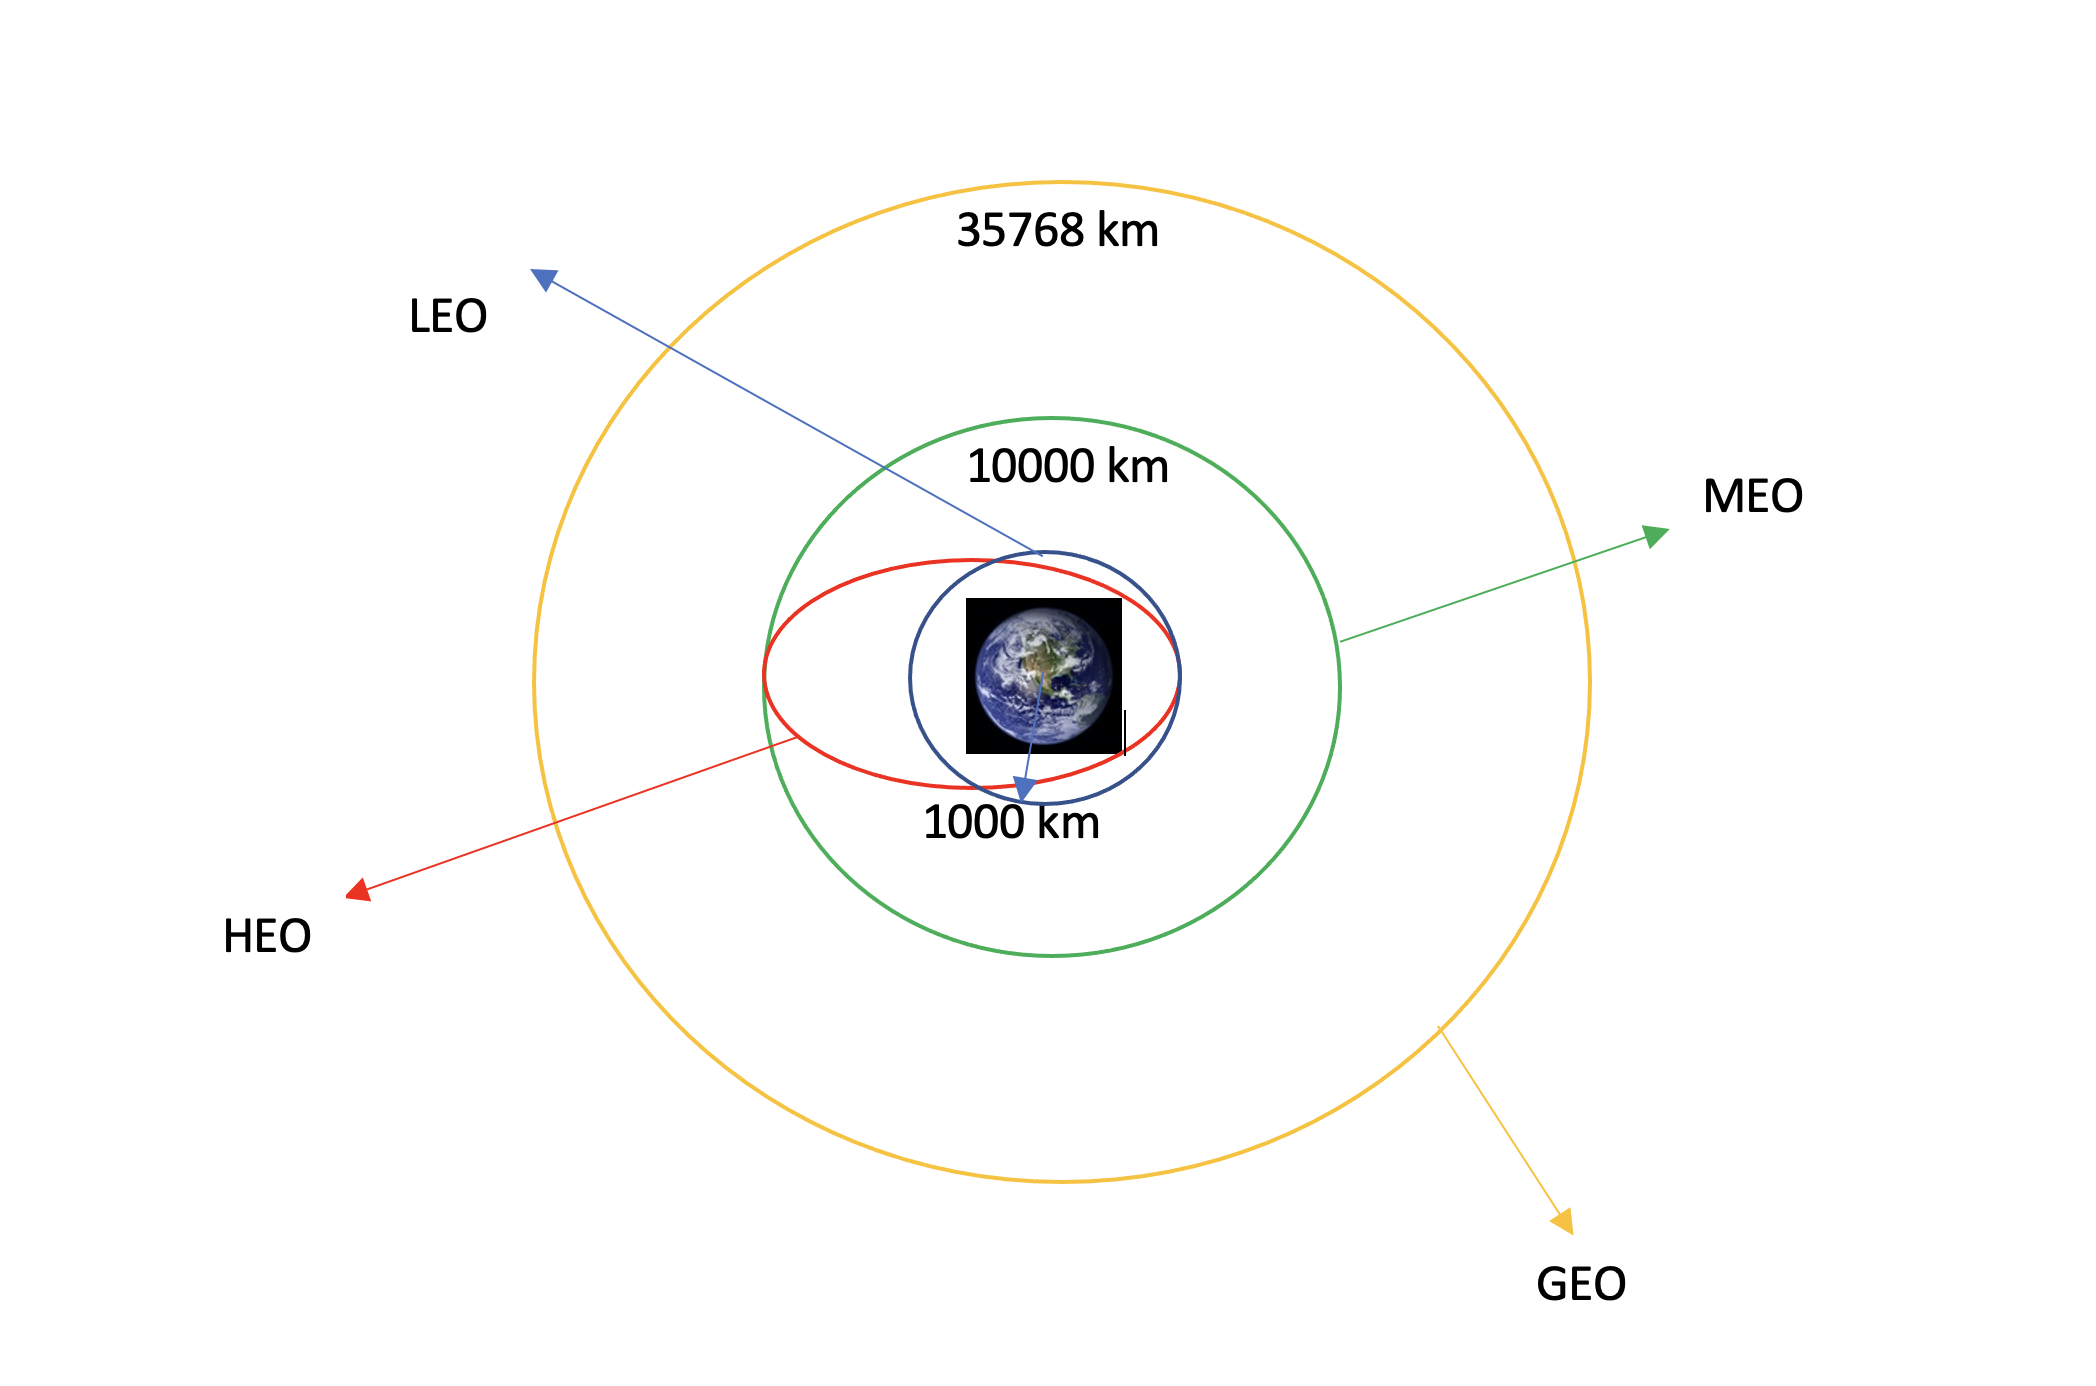

In [78]:
# Calculate the number and occurrence of each orbit
df.Orbit.value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [79]:
# Visualize within diagram
px.bar(df.Orbit.value_counts(), title='Number and Occurrence of Each Orbit')

In [80]:
# Calculate the number and occurence of mission outcome per orbit type
landing_outcomes = df.Outcome.value_counts()

In [81]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


* **True Ocean** means the mission outcome was successfully landed to a specific region of the ocean while **False Ocean** means the mission outcome was unsuccessfully landed to a specific region of the ocean
* **True RTLS** means the mission outcome was successfully landed to a ground pad **False RTLS** means the mission outcome was unsuccessfully landed to a ground pad
* **True ASDS** means the mission outcome was successfully landed to a drone ship **False ASDS** means the mission outcome was unsuccessfully landed to a drone ship.
* **None ASDS** and **None None** these represent a failure to land.

In [82]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [83]:
# Create a landing outcome label from Outcome column
df['Class'] = 1
df.loc[df.Outcome.isin(bad_outcomes), 'Class'] = 0

In [84]:
# Determine the success rate
df['Class'].mean()

0.6666666666666666

In [85]:
df.to_csv('dataset_part_2.csv',index=False)

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Visualize the relationship between Flight Number and PayloadMass

<Figure size 1000x1000 with 0 Axes>

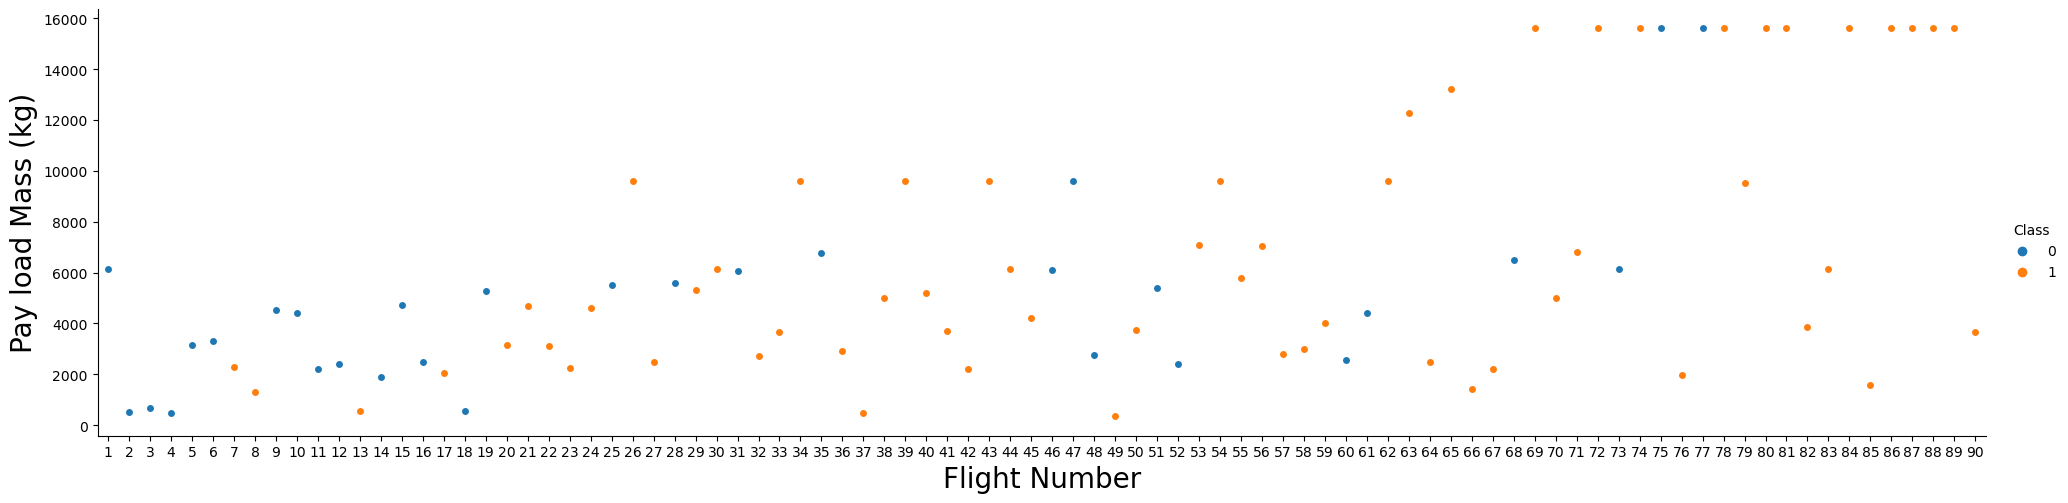

In [87]:
plt.figure(figsize=(10,10))
sns.catplot(data=df, x="FlightNumber", y="PayloadMass", hue="Class", aspect = 4)
# sns.scatterplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

#### Visualize the relationship between Flight Number and Launch Site

<Figure size 2000x700 with 0 Axes>

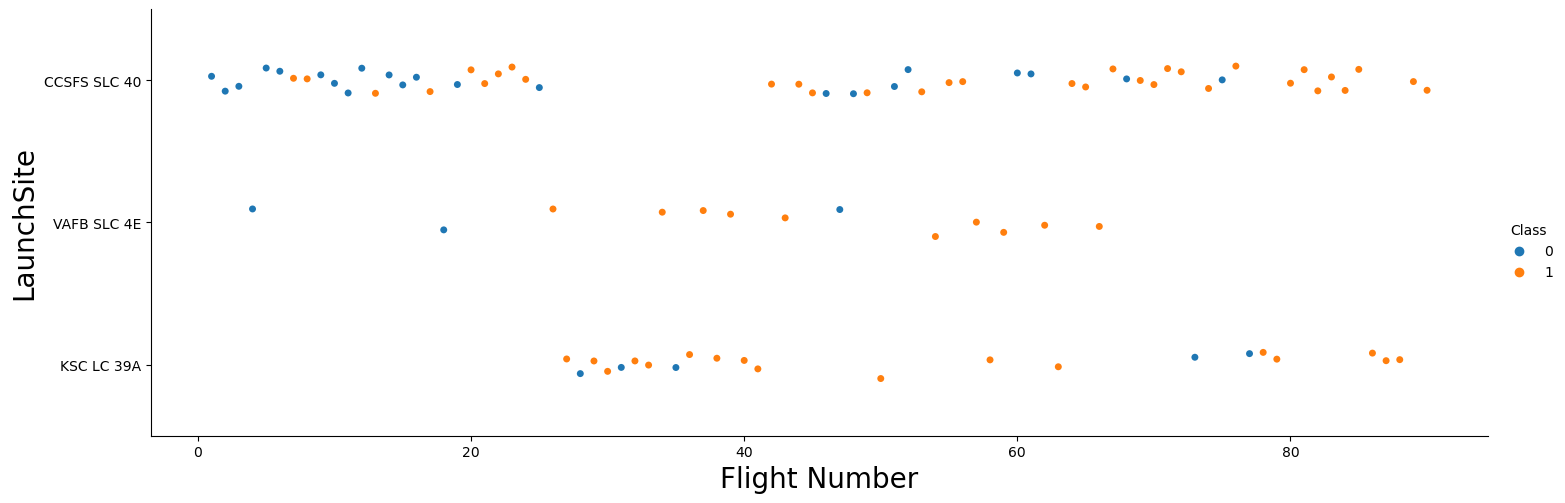

In [88]:
plt.figure(figsize=(20,7))
sns.catplot(data=df, x="FlightNumber", y="LaunchSite", hue="Class", aspect = 3)
# sns.scatterplot(data=df, x="FlightNumber", y="LaunchSite", hue="Class")
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

#### Visualize the relationship between Payload and Launch Site

<Figure size 2000x700 with 0 Axes>

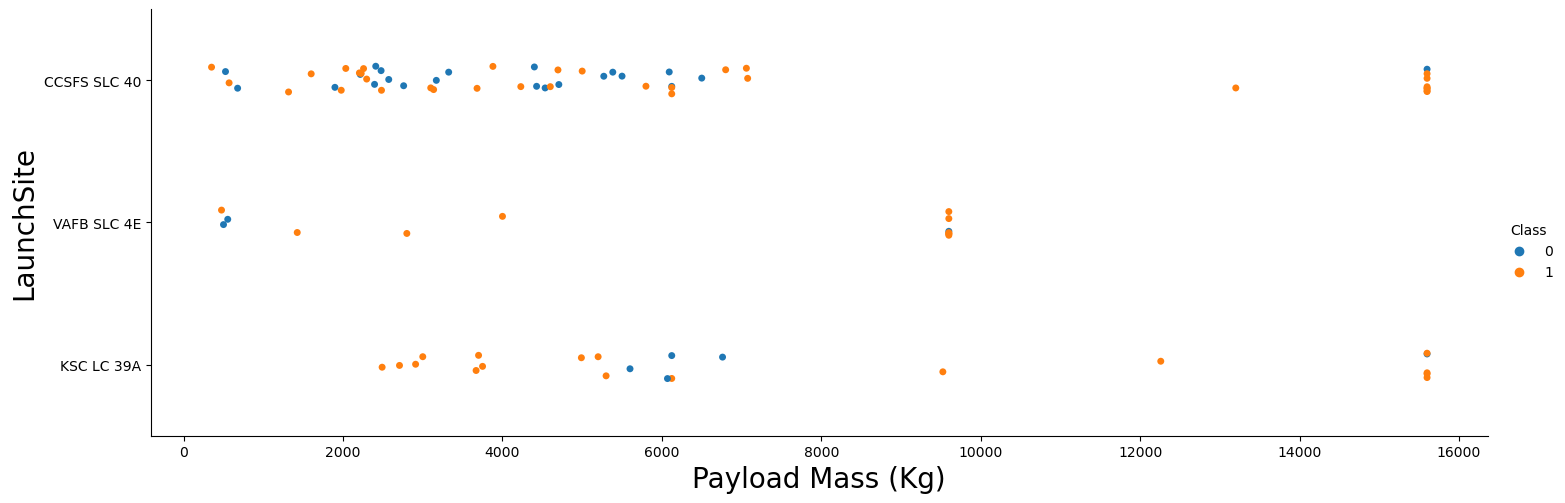

In [89]:
plt.figure(figsize=(20,7))
sns.catplot(data=df, x="PayloadMass", y="LaunchSite", hue="Class", aspect = 3)
# sns.scatterplot(data=df, x="FlightNumber", y="LaunchSite", hue="Class")
plt.xlabel("Payload Mass (Kg)",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

#### Visualize the relationship between success rate of each orbit type

In [90]:
px.bar(df.groupby('Orbit')['Class'].mean(),title='Relationship between Success Rate of Each Orbit Type')

#### Visualize the relationship between FlightNumber and Orbit type

<Figure size 2000x700 with 0 Axes>

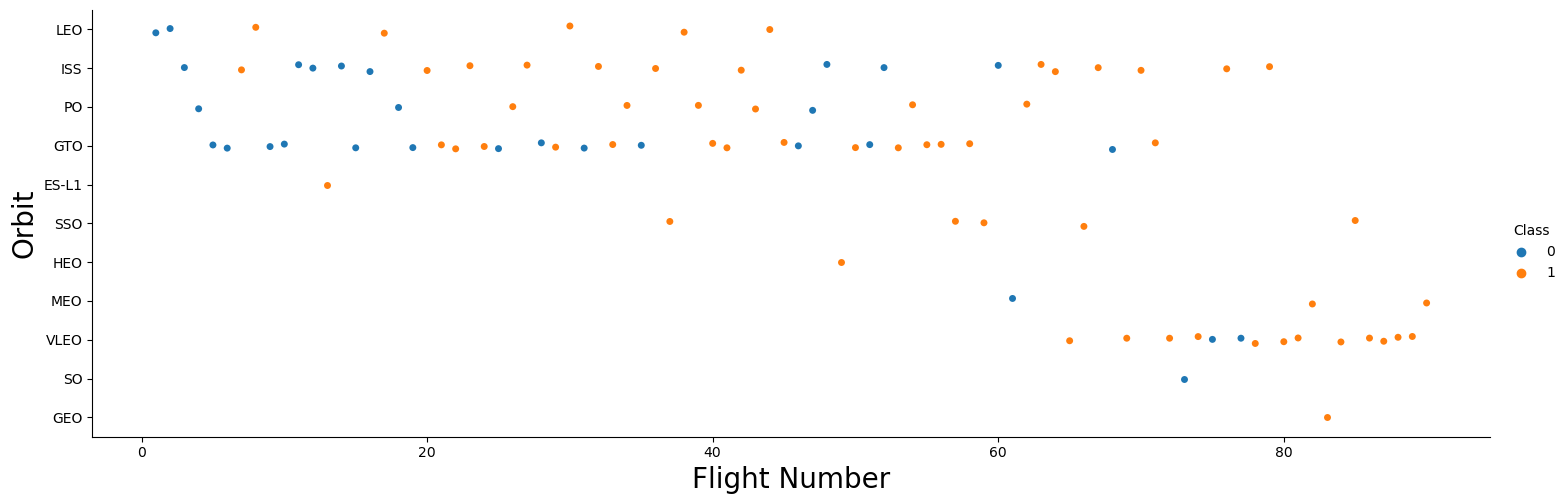

In [91]:
plt.figure(figsize=(20,7))
sns.catplot(data=df, x="FlightNumber", y="Orbit", hue="Class", aspect = 3)
# sns.scatterplot(data=df, x="FlightNumber", y="Orbit", hue="Class")
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

#### Visualize the relationship between Payload and Orbit type

<Figure size 2000x700 with 0 Axes>

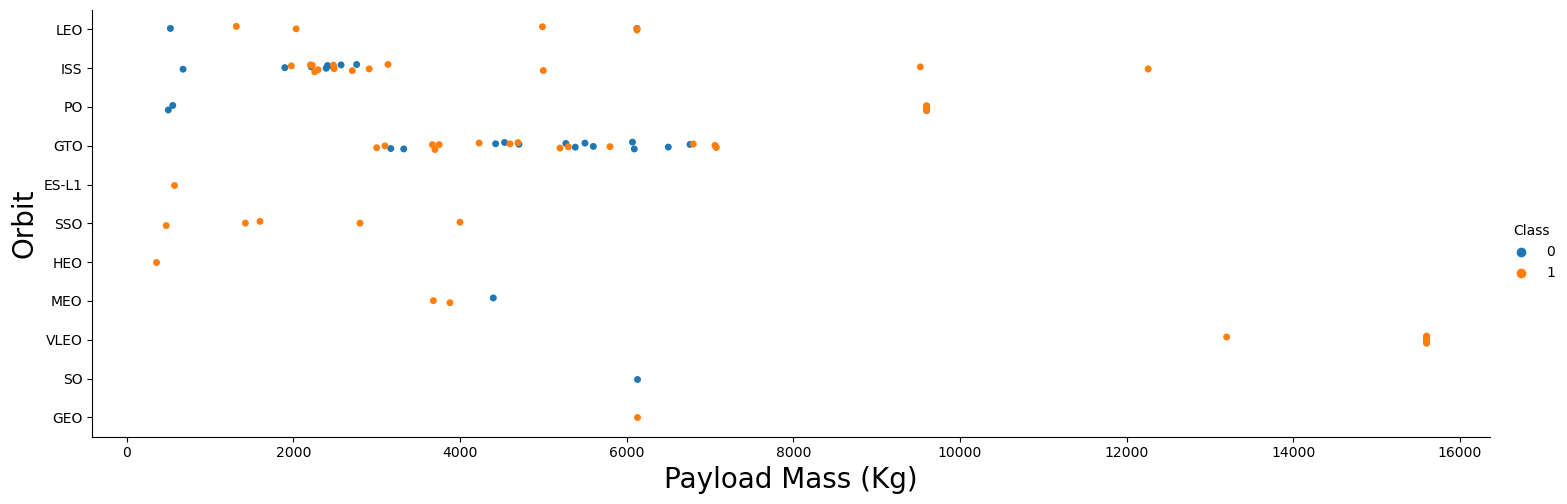

In [92]:
plt.figure(figsize=(20,7))
sns.catplot(data=df, x="PayloadMass", y="Orbit", hue="Class", aspect = 3)
# sns.scatterplot(data=df, x="PayloadMass", y="Orbit", hue="Class")
plt.xlabel("Payload Mass (Kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

#### Visualize the launch success yearly trend

In [102]:
df.groupby(df.Date.dt.year)['Class'].mean()*100

Date
2010     0.000000
2012     0.000000
2013     0.000000
2014    33.333333
2015    33.333333
2016    62.500000
2017    83.333333
2018    61.111111
2019    90.000000
2020    84.210526
Name: Class, dtype: float64

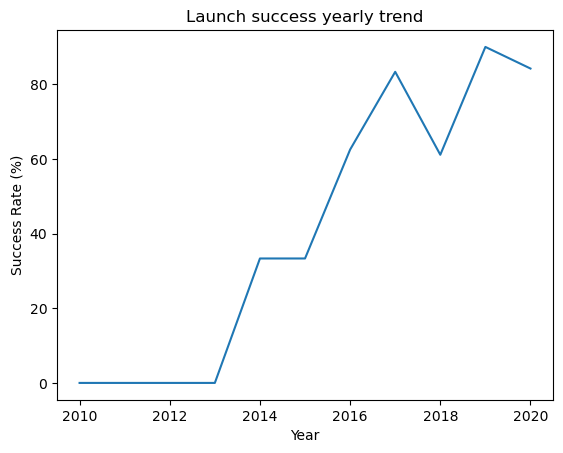

In [105]:
(df.groupby(df.Date.dt.year)['Class'].mean()*100).plot(kind='line',title='Launch success yearly trend')
plt.xlabel("Year",fontsize=10)
plt.ylabel("Success Rate (%)",fontsize=10)
plt.show()

## Feature Engineering

In [106]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Legs', 'Reused',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [107]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [111]:
features

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004
...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,VLEO,KSC LC 39A,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060
86,87,15600.000000,VLEO,KSC LC 39A,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058
87,88,15600.000000,VLEO,KSC LC 39A,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051
88,89,15600.000000,VLEO,CCSFS SLC 40,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060


In [120]:
features_one_hot = pd.get_dummies(features)
features_num = features_one_hot.select_dtypes(['int','float']).columns
features_one_hot[features_num] = features_one_hot[features_num].astype('float64')

In [122]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)